# 3. 繪圖基礎：畫等值地圖
 
首先用最簡單的方式，示範以`xarray`讀取netCDF格式資料、簡易運算和繪製等值地圖的過程。

**Example 1. 區域2017年12月平均外逸長波輻射 (outgoing longwave radiation, OLR)：** 繪製這個圖會經過幾個步驟
1. 開啟檔案。
2. 選取特定時空範圍。
3. 時間平均。
4. 繪圖。

```{note}
繪圖經度請先設定在0˚-180˚之內，跨越此範圍的繪圖方法比較複雜，我們會在第9單元說明。
```

## 讀取檔案並選擇時空範圍

In [1]:
import numpy as np
import xarray as xr 

# 選擇資料的時空範圍。
lats = -20
latn =  30
lon1 =  79 
lon2 = 161
time1 = '2017-12-01'
time2 = '2017-12-31'

# 開啟檔案
with xr.open_dataset("data/olr.nc") as olr_ds:   # with...as 使得dataset讀完就把檔案關起來，不佔記憶體。
     olr = (olr_ds.sel(time=slice(time1,time2),
                       lat=slice(lats,latn),
                       lon=slice(lon1,lon2)).olr)    # 將olr從Dataset中讀出來，成為一個DataArray

olr

<xarray.DataArray 'olr' (time: 31, lat: 50, lon: 82)>
[127100 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2017-12-01 2017-12-02 ... 2017-12-31
  * lon      (lon) float32 79.5 80.5 81.5 82.5 83.5 ... 157.5 158.5 159.5 160.5
  * lat      (lat) float32 -19.5 -18.5 -17.5 -16.5 -15.5 ... 26.5 27.5 28.5 29.5
Attributes:
    standard_name:  toa_outgoing_longwave_flux
    long_name:      NOAA Climate Data Record of Daily Mean Upward Longwave Fl...
    units:          W m-2
    cell_methods:   time: mean area: mean

一個Dataset會包括座標軸 (時間、空間)，以形成*n*-D的變數場 (如下圖中的立體方塊temperature, precipitation)，這些由座標軸建構出的變數場在xarray中稱為DataArray。一個Dataset可以包含很多個不同變數的DataArray。
  
![](http://xarray.pydata.org/en/stable/_images/dataset-diagram.png)
  
以上我們還示範了如何利用`slice`選擇資料時空範圍，xarray.DataArray和np.array最大的差別就是，DataArray包含了座標軸，因此選擇範圍的時候可以直接用實際的資料時空範圍來選取，不必去找25˚S和25˚N分別在緯度軸的第幾格才能選取，非常方便。選取資料的方式除了`slice`是選擇實際的時間和經緯度範圍之外 (by label)，還有多種方式，例如也可以選第幾個陣列的格點 (by integer)。[xarray網站](https://xarray.pydata.org/en/stable/user-guide/indexing.html)有表格整理，附如下。

![](https://i.imgur.com/fko7ZLv.png)

**Note:** Dataset沒有positional index selection，因為Dataset裡面可以包含很多變數DataArray，這些DataArray可以擁有彼此不同的座標軸，所以positional index selection會讓程式很混淆，沒有選擇的依據。

## 分析計算

接下來，我們要對時間軸進行平均，在方法`mean`引數中可以指定要做平均的維度，如以下範例指定`olr`這個DataArray的第0個軸進行平均，也就是time這個軸（也可以寫`dim='time'`）。
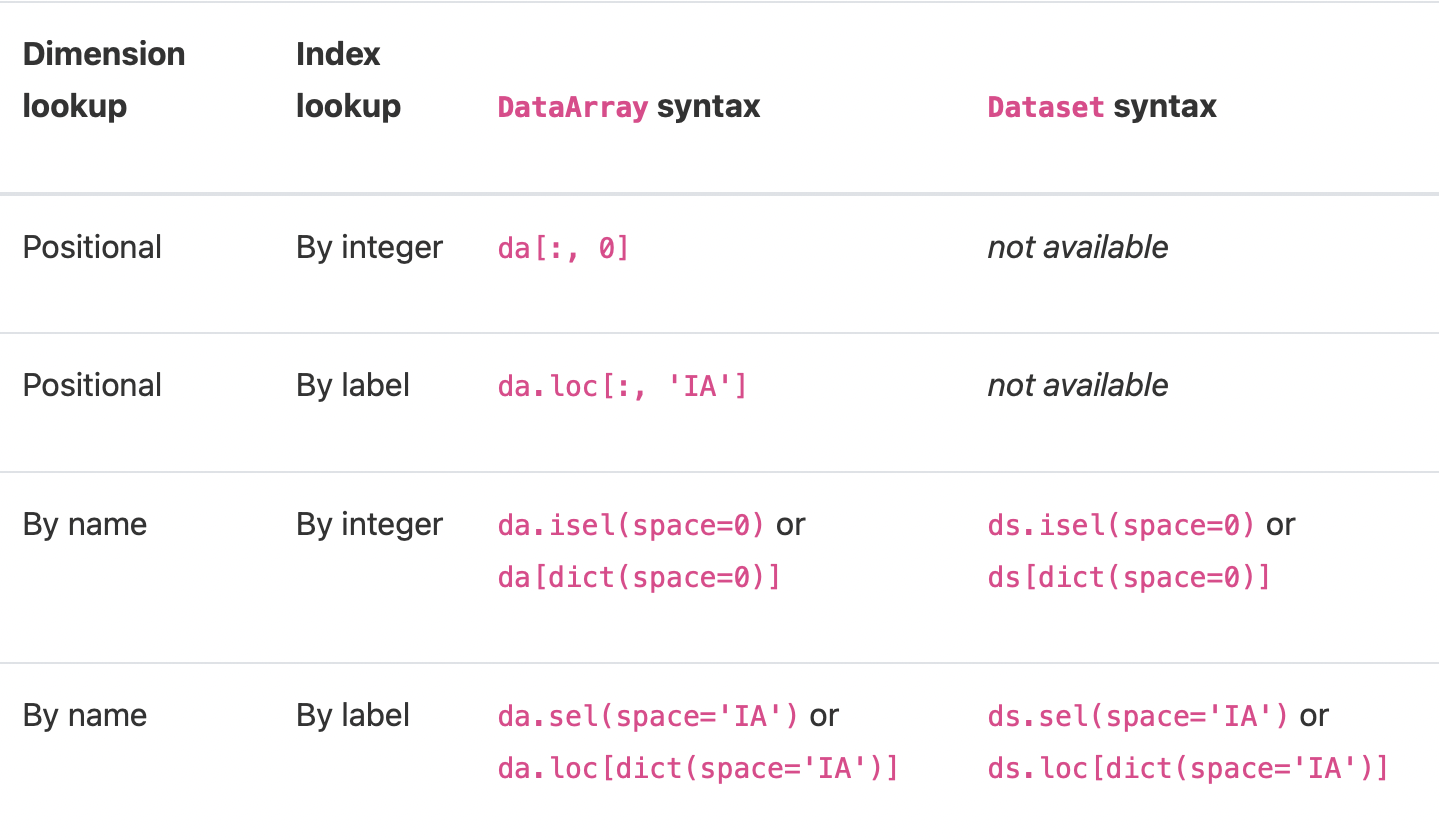

In [2]:
# 對時間軸axis = 0 進行平均。                       
olrm = olr.mean(axis=0)
olrm

<xarray.DataArray 'olr' (lat: 50, lon: 82)>
array([[287.4708 , 287.87192, 286.90723, ..., 271.47592, 269.68332,
        266.63043],
       [285.6799 , 285.8262 , 286.34995, ..., 268.567  , 266.5395 ,
        263.9603 ],
       [282.36685, 283.75674, 285.1209 , ..., 267.8831 , 264.08185,
        260.59106],
       ...,
       [262.47873, 264.25   , 263.49432, ..., 269.69827, 271.77063,
        273.64374],
       [261.1402 , 261.74628, 260.309  , ..., 260.9607 , 262.55548,
        263.67596],
       [253.06664, 249.58241, 238.8812 , ..., 252.71883, 254.02852,
        255.21298]], dtype=float32)
Coordinates:
  * lon      (lon) float32 79.5 80.5 81.5 82.5 83.5 ... 157.5 158.5 159.5 160.5
  * lat      (lat) float32 -19.5 -18.5 -17.5 -16.5 -15.5 ... 26.5 27.5 28.5 29.5

如此一來，`olr`就從三維被縮減為二維的陣列了。

## 繪圖

接著就要將平均好的結果`olrm`繪製成等值地圖。

### `matplotlib`繪圖基本原理

既然matplotlib是PyAOS的核心套件，我們先來了解一下用Matplotlib繪圖的原理。首先必須開啟一個 **畫布** (習慣上用`fig`來表示)，而畫布上會有許多的 **子圖** (subplots)，這些子圖一般用`ax`來表示。而開啟畫布和子圖有兩種方式，第一種利用 `Matplotlib.figure.figure.add_subplot()`，

```
add_subplot(nrows, ncols, index, **kwargs)
```

也就是在指定位置上開啟一個子圖，位置指定的方式就是給定第幾列 (`nrows`)和第幾行(`ncols`)。現在我們只需要開啟一個子圖，因此三個引數都設定為1就可以了。

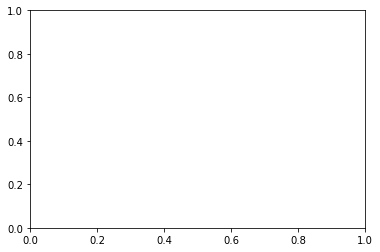

In [3]:
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

第二種方式是利用`Matplotlib.pyplot.subplots()`來新增子圖：

```
matplotlib.pyplot.subplots(nrows, ncols,...)
```

這個指令會根據給定的行、列子圖數量 (`nrows`和`ncols`) 來開啟一個已劃分好子圖的畫布。

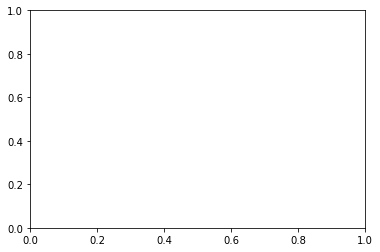

In [4]:
fig,ax=plt.subplots(1,1)

### xarray的繪圖函數

開好繪圖區後，就可以在子圖`ax`上畫圖了。`xarray.Dataset`和`xarray.DataArray`有內建的繪圖方法`xarray.DataArray.plot.contourf`等，其會將引數設定傳送到`matplotlib`的繪圖函數中，進而畫在`ax`上。其他繪圖方法還有 `xarray.plot.pcolormesh()`、`xarray.plot.contour()`⋯⋯等多種，在第八、九單元我們還會詳細說明。

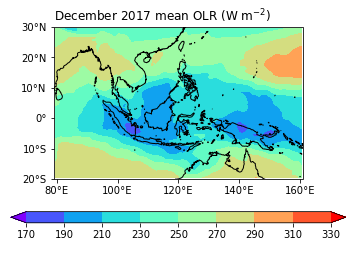

In [5]:
from cartopy import crs as ccrs   
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# 繪圖：開啟繪圖空間與地圖設定。
proj = ccrs.PlateCarree()      # 採用等距地圖投影。
fig,ax = plt.subplots(1,1,subplot_kw={'projection':proj})   # 利用matplotlib開啟畫布以及1 x 1的繪圖區。

clevs = np.arange(170,350,20)

# 繪圖
plt.title("December 2017 mean OLR (W m$^{-2}$)", loc='left')    # 設定圖片標題，並且置於圖的左側。
olrPlot = (olrm.plot.contourf("lon",              # 設定x坐標。
                              "lat",              # 設定y坐標。
                              transform=proj,     # 指定「資料本身」的網格系統。
                              ax=ax,              # 繪製在繪圖空間ax上。
                              levels=clevs,       # 設定圖例色階間距。
                              cmap='rainbow',     # 設定色階
                              add_colorbar=True,  # 繪製色階。
                              extend='both',      # 色階向兩端延伸。
                              cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'label': ' '}) #設定color bar
                              )

ax.set_extent([lon1,lon2,lats,latn],crs=proj)
ax.set_xticks(np.arange(80,180,20), crs=proj)
ax.set_yticks(np.arange(-20,40,10), crs=proj)   # 設定x, y座標的範圍，以及多少經緯度繪製刻度。
lon_formatter = LONGITUDE_FORMATTER
lat_formatter = LATITUDE_FORMATTER   
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)  # 將經緯度以degN, degE的方式表示。
ax.coastlines()                # 繪製地圖海岸線。                              
ax.set_ylabel(' ')             # 設定坐標軸名稱。
ax.set_xlabel(' ')
plt.show()
#plt.savefig("olr_mean_201712.png", dpi=600)  # 儲存圖片。

補充說明：

1. Cartopy是繪製地圖、處理投影的函數。在開啟子圖時，需要先用`subplot_kw={'projection':proj}`來指定子圖的投影方式。

2. cmap可以使用[Matplotlib的色階](https://matplotlib.org/stable/tutorials/colors/colormaps.html)，只要在網站中搜尋到適合的，然後在`plot.contourf`中`cmap`的引數填入色階名稱即可。

3. 除了Matplotlib的色階之外，也可以使用[NCL Colar Table Gallery](https://www.ncl.ucar.edu/Document/Graphics/color_table_gallery.shtml#matplotlib)的色階，使用上請先`import cmaps`這個套件，而NCL網站上色階的名稱就是`cmaps`套件的attribute。舉例而言，如果想要使用"GMT_seis"這個色階，在`plot.contourf`中`cmap`的引數填入`cmap=cmaps.GMT_seis`即可。

## 輸出為netCDF檔

計算完的結果`olrm` (是一個DataArray) 也可以另外儲存成netCDF檔案。輸出後我們也用ncdump來查詢一下檔案的資訊。

In [6]:
olrｍ.to_netcdf("olrm_201712.nc")

import os
os.system('ncdump -h olrm_201712.nc')

netcdf olrm_201712 {
dimensions:
	lon = 82 ;
	lat = 50 ;
variables:
	float lon(lon) ;
		lon:_FillValue = NaNf ;
		lon:standard_name = "longitude" ;
		lon:long_name = "longitude" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
		lon:bounds = "lon_bnds" ;
	float lat(lat) ;
		lat:_FillValue = NaNf ;
		lat:standard_name = "latitude" ;
		lat:long_name = "latitude" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
		lat:bounds = "lat_bnds" ;
	float olr(lat, lon) ;
		olr:_FillValue = NaNf ;
}


0

## 小結

以上我們按照開啟檔案、分析資料、視覺化這樣的氣候資料處理最基本的流程，示範了如何將OLR資料進行月平均，並繪製成等值圖。xarray是一個很方便的工具，簡化了許多流程，整體來說讓程式碼變得非常簡潔。